# CAmping Initiation - Data Wrangling & Exploration

This notebook is for exploring the preprocessed data.
This notebooks is implemented in the wrangle.py file.

In [10]:
# Get the notebook imports
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from nltk.util import ngrams
from nltk import FreqDist
import matplotlib.pyplot as plt
from nltk.tokenize import MWETokenizer
%matplotlib inline

plt.rcParams["figure.figsize"] = (30,15)
plt.rcParams["xtick.labelsize"] = 20

Read in the preprocessed dataset. 

In [2]:
_data = pd.read_csv("PROCESSED_LABELED.csv")
_data.head()

,question_text,code
0,I know what my goals are and what I need to do...,ALI.5
1,I feel like I can be successful in my role,ALI.5
2,30. I know what I need to do to be successful ...,ALI.5
3,I understand my role and what is expected of me,ALI.5
4,I know what is expected of me in my role.,ALI.5


#### Class Distributions
The distribution of classes can make a significant impact on our machine learning algorithm. The result below shows that the class imbalance isn't too bad. It's not perfect, but for the purpose of the excercise we can atleast try our initial run without subsampling.

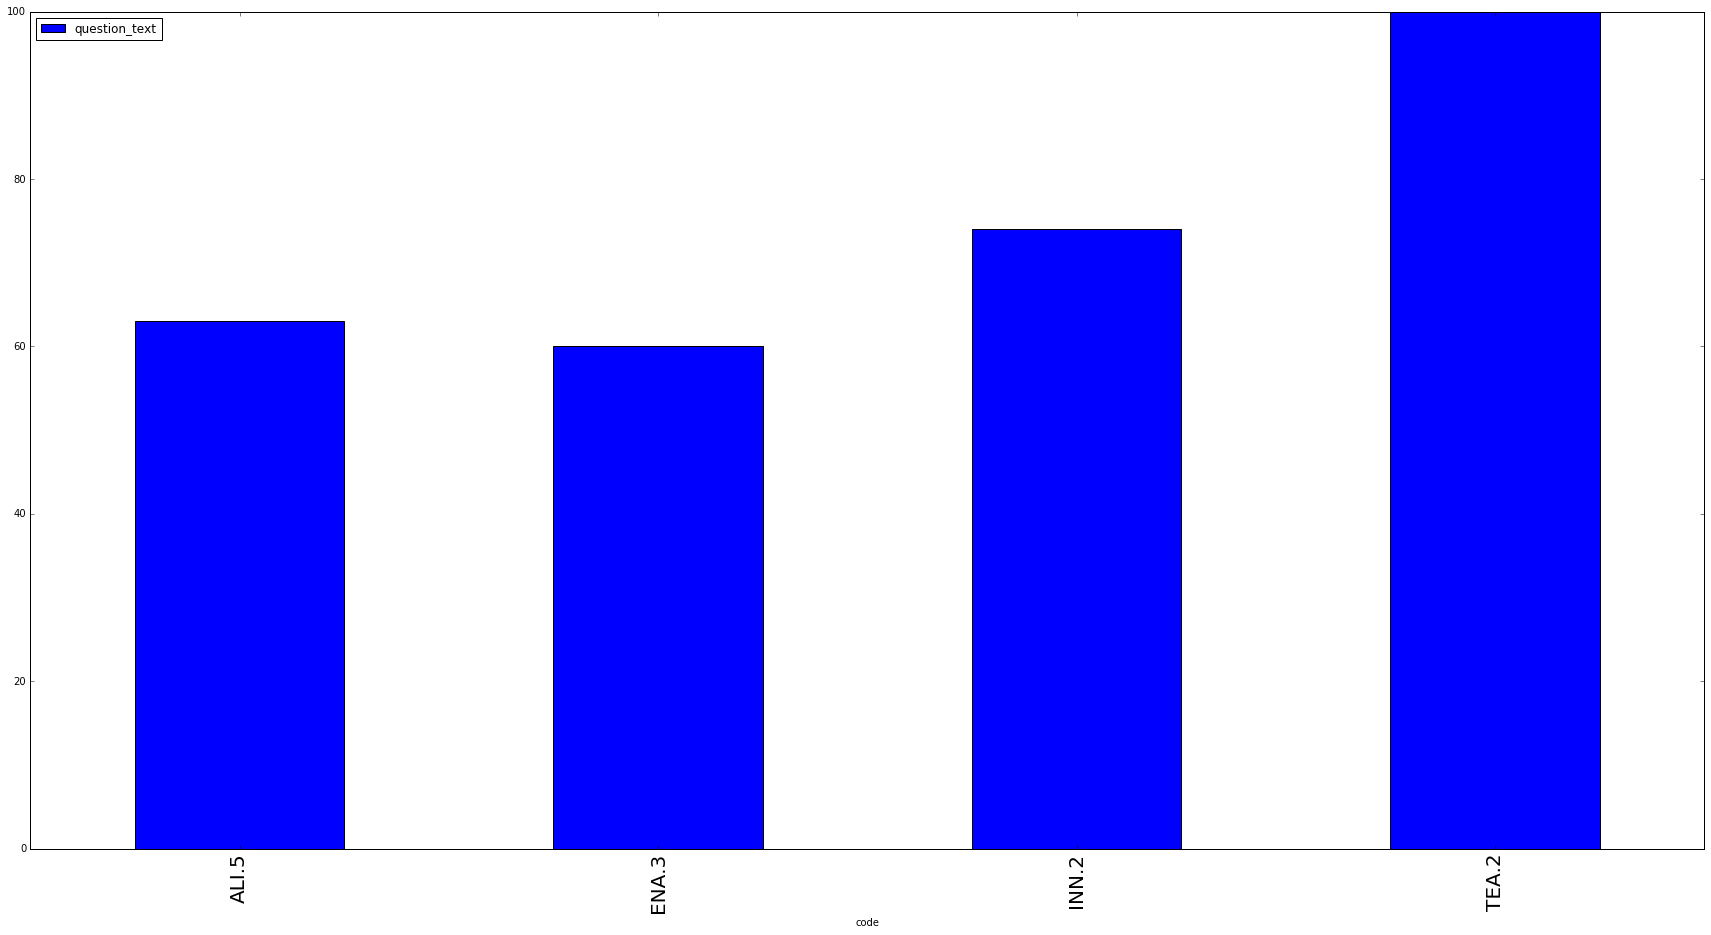

In [3]:
_data.groupby(['code']).count().reset_index().plot(kind='bar', x='code')
plt.show()

#### Text processing & exploration
Let's take some easy steps to have a look at our collection. First we will cast all items to lower case. We are assuming the the case of the letters has nothing to do with the class label. Given that it's a question, not an answer, probably not such a bad assumption.

In [4]:
_data['question_text'] = _data['question_text'].str.lower() # Assign it to self.

Let's tokenize our entire set. We probably should have split a training and testing set, but given that they gave us some test questions, we can use that as our test and validation set. 
Also, being realistic, we won't have time to do anything fancy, let's use a bag of words approach to modelling this system. We will also use a simple whitespace tokenizer to generate the bag of words too.

In [5]:
# Set up a helper function to take a string and a regex pattern then return the corresponding tokens in the string.
def getTokensFromString(string, regexPattern=r'\W+'):
    # type: (str,str) -> list
    """
    This method returns a list of tokens separated by whitespace.
    :param string: String to be tokenized.
    :param regexPattern: Regular expression pattern to tokenize on. Defaults to whitespace.
    :return: List containing the tokens.
    """

    _tokenizer = RegexpTokenizer(regexPattern, gaps=True)
    return _tokenizer.tokenize(string)

# Generate the wordbag
_wordBag = map(lambda x: getTokensFromString(x),_data['question_text'].tolist())

# When this is iterated over, it generates a list of lists, so let's flatten them out into one bag.
_flatBag = [word for wordList in list(_wordBag) for word in wordList]
len(_flatBag)

3548

Just from looking at the head of the dataset, we noticed some numeric values as well. Again, for simplicity we will assume that these are not relevant to classifying the class label.

In [6]:
_flatBag = [word for word in _flatBag if not word.isdigit()]
len(_flatBag)

3535

##### Bigrams & Trigrams
n-grams are good way to identify common sequences of words. We will first look at the distribution of n-grams to see if there are indeed a large number of common patterns. Let's start from uni-grams and go till tri-grams.

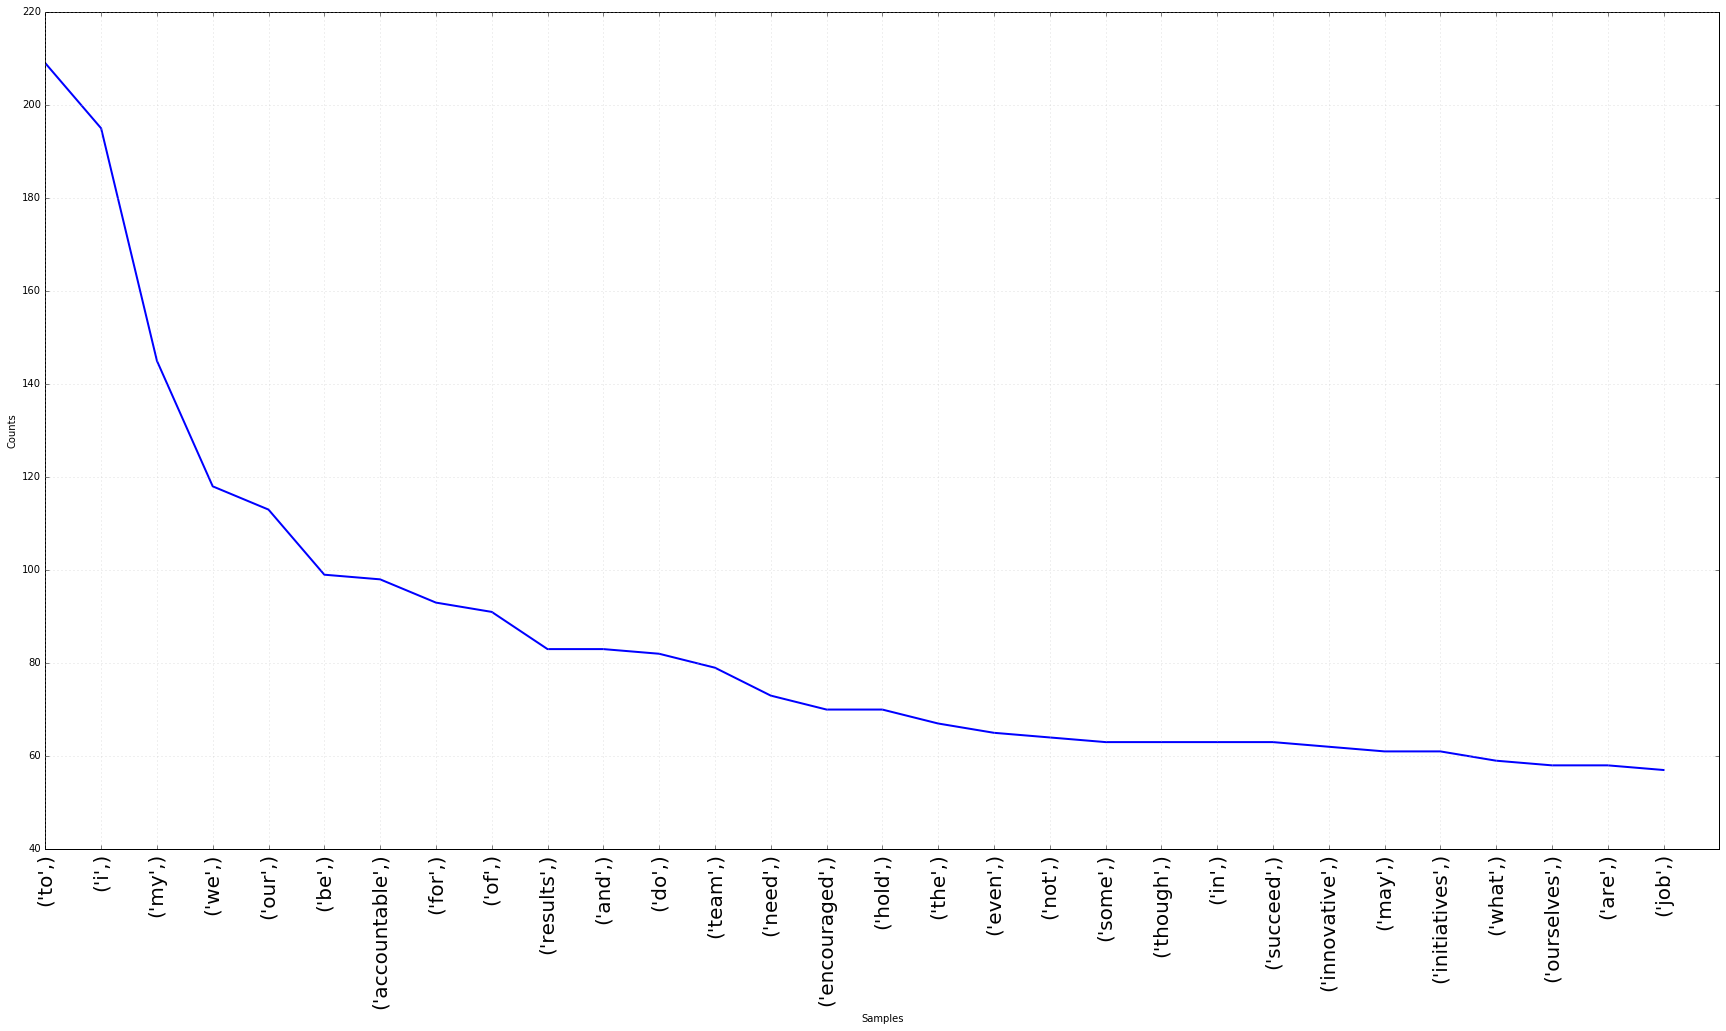

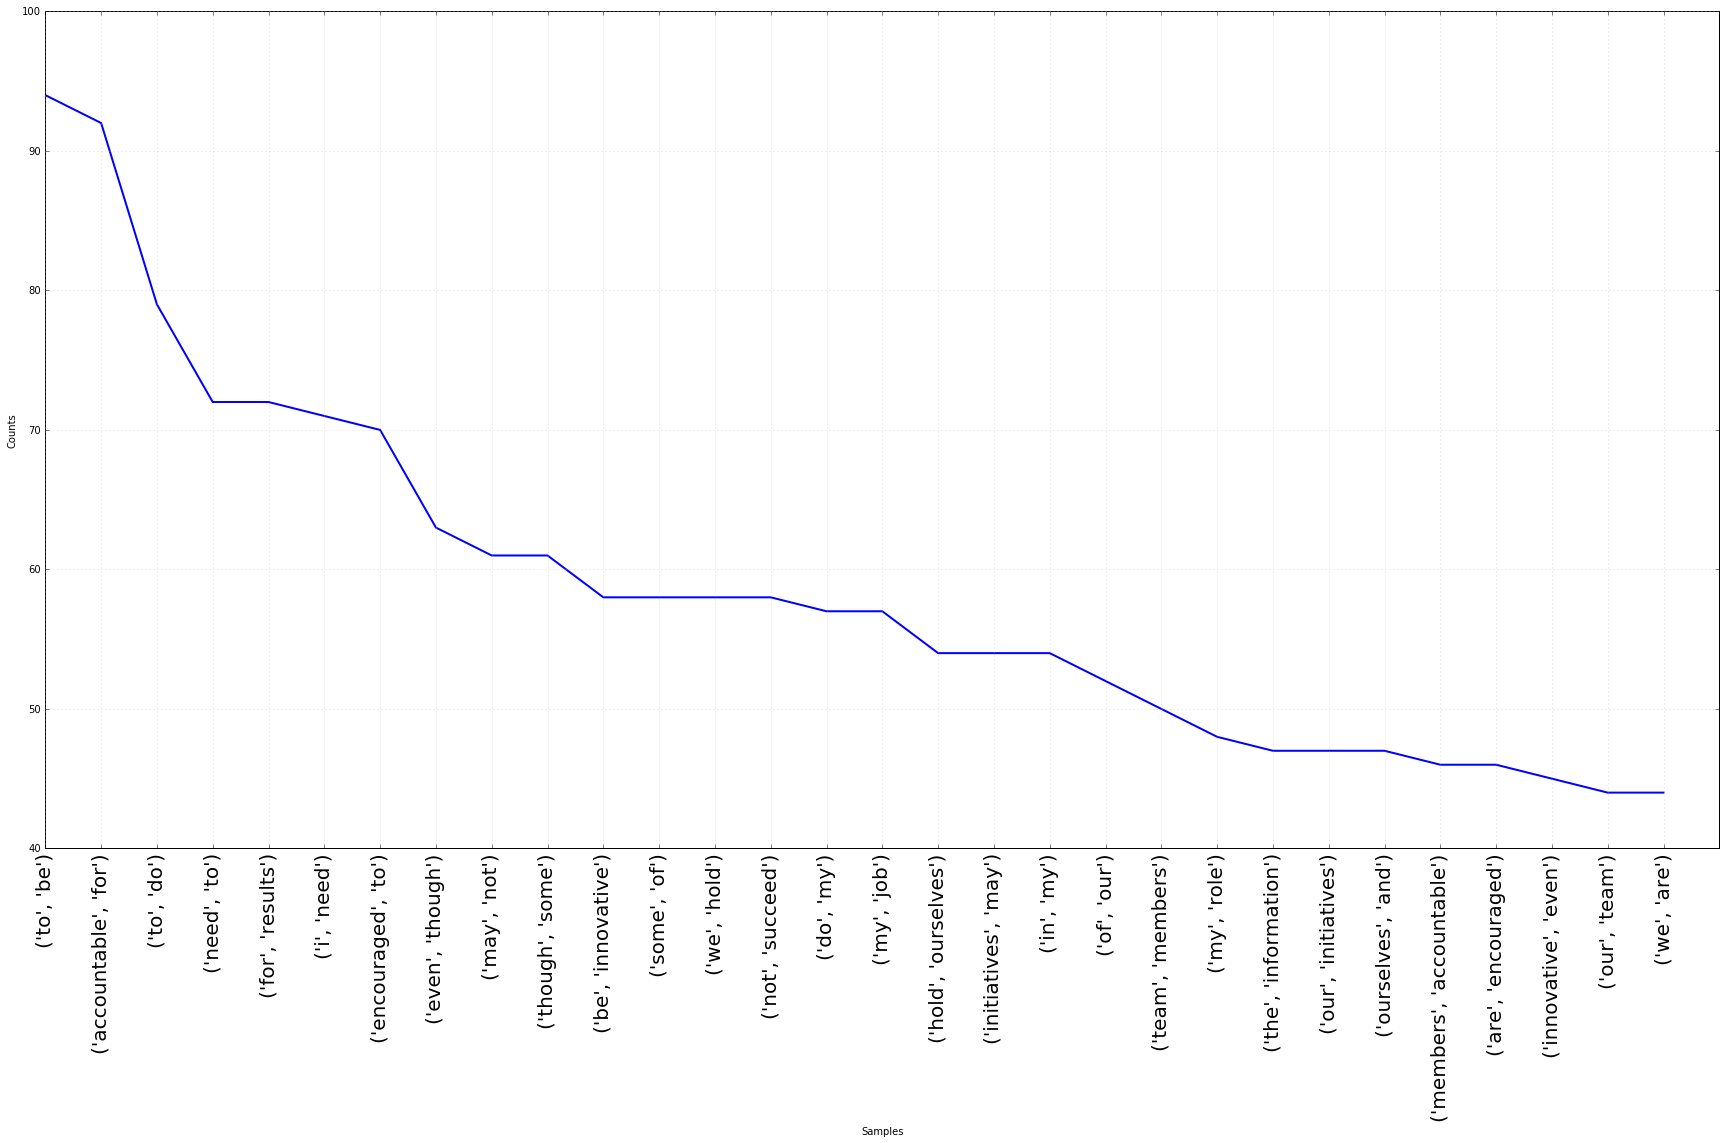

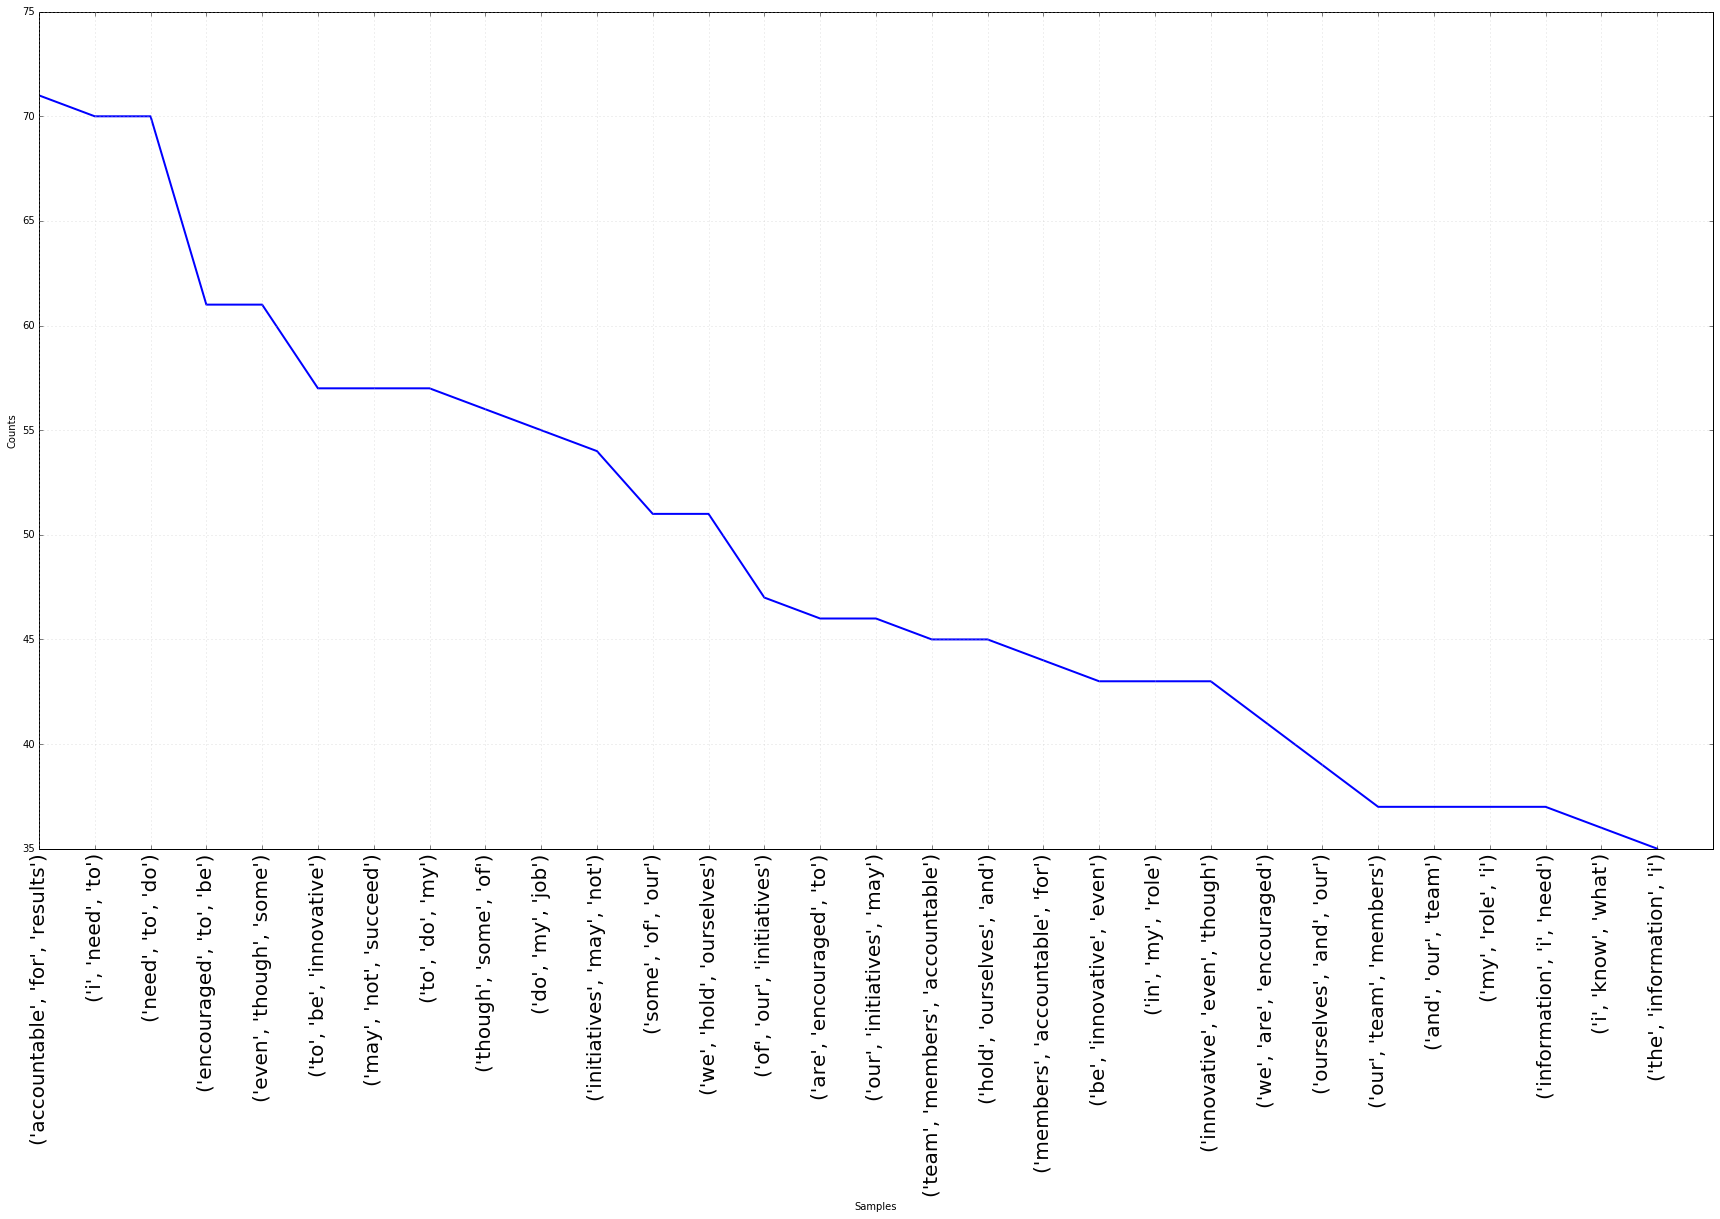

In [7]:
_unigrams = FreqDist(ngrams(_flatBag, n=1))
_unigrams.plot(30)
_bigrams = FreqDist(ngrams(_flatBag, n=2))
_bigrams.plot(30)
_trigrams = FreqDist(ngrams(_flatBag, n=3))
_trigrams.plot(30)

Well certainly looks like 'to' and 'i' seem to be stop-characters. But they seem to be part of alot of bi-grams and tri-grams. Interesting. Let's retokenize using some of these bigrams and trigrams.

In [8]:
# Generate a wrapper function for multi-word tokenization.
def getMWETokenizer(nGrams):
    # type: (list) -> MWETokenizer
    """
    We need to generate a multi word expression tokenizer using ngrams that have been identified.
    :param nGrams: List containing nltk.probability.FreqDist objects.
    :return: Tokenizer object.
    """
    _tk = MWETokenizer(separator=' ')
    for i in nGrams:
        _tk.add_mwe(i[0])

    return _tk


# Wrapper for generating tokens with a tokenizer that has ngrams defined.
def getMWETokens(string, tokenizer):
    # type: (str,MWETokenizer) -> list
    """
    This wrapper will generate tokens for a given string using the the specified MWETokenizer.
    :param string: String to be tokenized.
    :param tokenizer: Tokenizer to be used for tokenization.
    :return: list of tokenized strings.
    """
    return tokenizer.tokenize(string.split())

Let's generate tokens using the 10 most common bigrams and trigrams. 

In [12]:
# Get the tokenizer.
_mweTokenizer = getMWETokenizer(_bigrams.most_common(10) + _trigrams.most_common(10)) 
# Map the token generation function
_mweWordBag = map(lambda x: getMWETokens(x, _mweTokenizer), _data['question_text'].tolist())

# Flatten
_mweWordBagFlat = _mweWordBagFlat = [word for wordList in list(_mweWordBag) for word in wordList]
len(_mweWordBagFlat)

2734